# 01_Perturbation-Based

In [1]:
import os
import cv2
import math
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

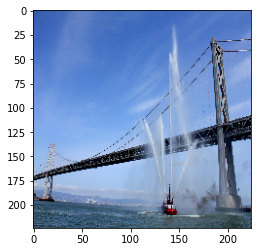

In [4]:
model = tf.keras.applications.resnet50.ResNet50(
    weights="imagenet", include_top=True
)
img_path = "data/fireboat.jpg"
image = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)
plt.imshow(image/255)

## [Occlusion Sensitivity (Zeiler & Fergus 14)](https://arxiv.org/abs/1311.2901)

In [21]:
batch_size = 16
patch_size = 32
class_index = 554
grid = math.ceil(image.shape[0]/patch_size)

In [22]:
def apply_grey_patch(image, top_left_x, top_left_y, patch_size):
    
    patched_image = np.array(image, copy=True)
    patched_image[
        top_left_y : top_left_y + patch_size, top_left_x : top_left_x + patch_size, :
    ] = 127.5

    return patched_image

In [23]:
sensitivity_map = np.zeros(
    (
        math.ceil(image.shape[0] / patch_size),
        math.ceil(image.shape[1] / patch_size),
    )
)

patches = [
    apply_grey_patch(image, top_left_x, top_left_y, patch_size)
    for index_x, top_left_x in enumerate(range(0, image.shape[0], patch_size))
    for index_y, top_left_y in enumerate(range(0, image.shape[1], patch_size))
]

coordinates = [
    (index_y, index_x)
    for index_x in range(
        sensitivity_map.shape[1]  # pylint: disable=unsubscriptable-object
    )
    for index_y in range(
        sensitivity_map.shape[0]  # pylint: disable=unsubscriptable-object
    )
]

In [24]:
predictions = model.predict(np.array(patches), batch_size=batch_size)
target_class_predictions = [
    prediction[class_index] for prediction in predictions
]

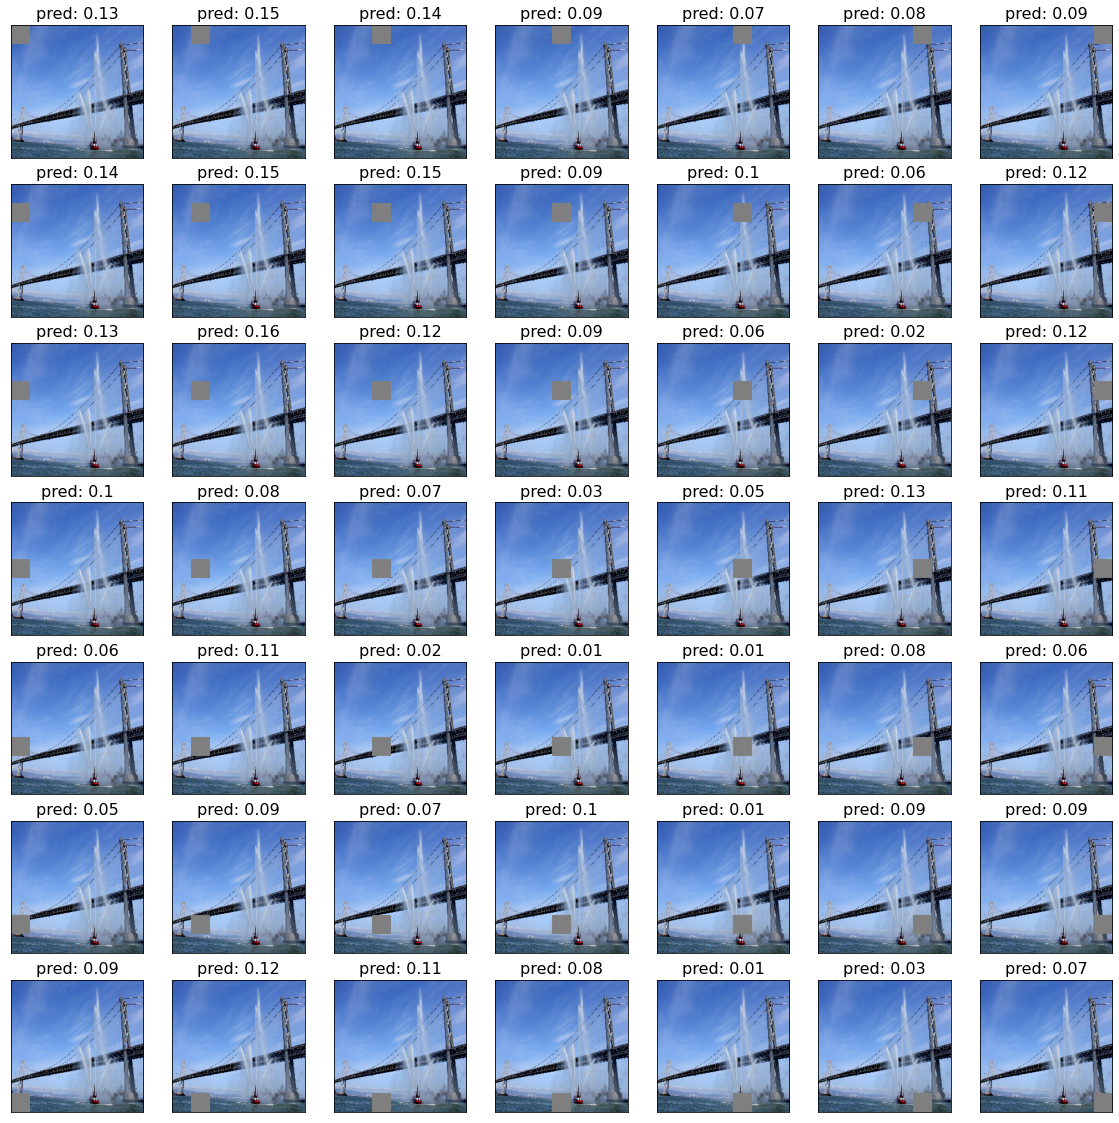

In [25]:
fig, ax = plt.subplots(nrows=grid, ncols=grid, figsize=(20, 20),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.2, wspace=0.1))
for i in range(len(patches)):
    ax[i%grid, i//grid].set_title('pred: '+ str(round(target_class_predictions[i], 2)), fontsize=16)
    ax[i%grid, i//grid].imshow(patches[i]/255)

In [26]:
for (index_y, index_x), confidence in zip(
    coordinates, target_class_predictions
):
    sensitivity_map[index_y, index_x] = 1 - confidence
    
sensitivity_maps = cv2.resize(sensitivity_map, image.shape[0:2])

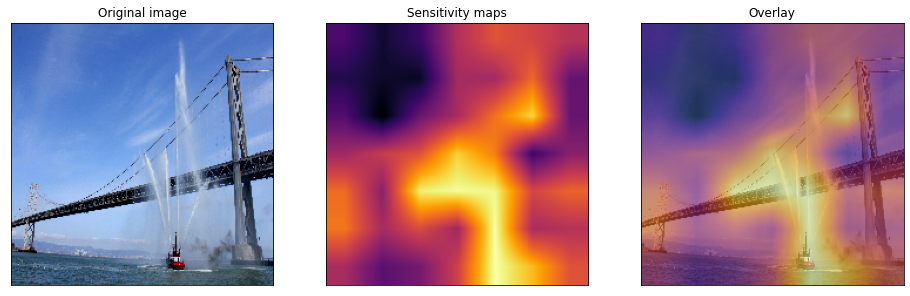

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Original image')
axs[0, 0].imshow(image/255)

axs[0, 1].set_title('Sensitivity maps')
axs[0, 1].imshow(sensitivity_maps, cmap=cm.inferno)

axs[0, 2].set_title('Overlay')
plt.imshow(sensitivity_maps, cmap=cm.inferno)
plt.imshow(image/255, alpha=0.4)

## 練習時間：
### 自己更改 patch_size 練習看看